In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import pandas as pd
import plotly.express as px

In [2]:
sns.set()

## Factory data

In [3]:
df_wide = pd.read_csv("../data/factory.csv")
df_wide.set_index("measurement", inplace=True)
df_wide.columns.name = "machine"
df_wide

machine,M1,M2,M3,M4,M5,M6
measurement,,,,,,
0,83.0,117.0,101.0,105.0,79.0,57.0
1,92.0,109.0,93.0,119.0,97.0,92.0
2,92.0,114.0,92.0,116.0,103.0,104.0
3,46.0,104.0,86.0,102.0,79.0,77.0
4,67.0,87.0,67.0,116.0,92.0,100.0


A "wide" format is more convenient for the following analyises. Let us melt the dataframe!

In [4]:
df = pd.melt(df_wide.reset_index(),
             id_vars=["measurement"],
             value_vars=['M1', 'M2', 'M3', 'M4', 'M5', 'M6'],
             value_name='quality')
df["machine"] = df["machine"].astype("category")
df.head()

,measurement,machine,quality
0,0,M1,83.0
1,1,M1,92.0
2,2,M1,92.0
3,3,M1,46.0
4,4,M1,67.0


## Some traditional analysis

* Obtain the pooled (global) mean and standard deviation of quality measurement

In [5]:
df["quality"].mean(), df["quality"].std()

(92.93333333333334, 18.001787906096773)

* Plot the histogram of the quality measurement

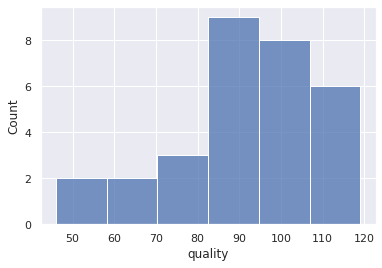

In [6]:
sns.histplot(df["quality"]);
#px.histogram(df["quality"]);

* Obtain the mean and standard deviation of quality measurement, for the different machines

In [7]:
df.groupby("machine")[["quality"]].agg(["mean", "std"])

quality           
           mean        std
machine                   
M1         76.0  19.634154
M2        106.2  11.819475
M3         87.8  12.794530
M4        111.6   7.569676
M5         90.0  10.770330
M6         86.0  19.222383

* Draw boxplots of quality for the different facto

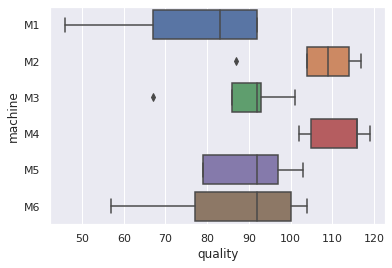

In [8]:
sns.boxplot(data=df, x="quality", y="machine");
#px.box(df, x="quality", y="machine")

Even from a classical analysis, there seems to be evidence that different machines have different quality

## Pooled Bayesian model

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu, \sigma) \\
\mu &\sim \mathcal{N}(92, 100) \\
\sigma &\sim |\mathcal{N}|(0, 100) \\
\end{align*}


* Implement the pooled model in pymc3

In [9]:
pd.DataFrame(stats.halfnorm.rvs(size=1000, scale=15)).describe()

,0
count,1000.000000
mean,11.811127
std,8.580700
min,0.048233
25%,4.874606
50%,10.239533
75%,16.881512
max,53.422089


In [10]:
with pm.Model() as model_pooled:
    mu = pm.Normal('mu', mu=92.5, sd=10)
    std = pm.HalfNormal('std', sd=15)
    y = pm.Normal('y', mu=mu, sd=std, observed=df["quality"])
    trace_pooled = pm.sample(10_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.882306153447509, but should be close to 0.8. Try to increase the number of tuning steps.


In [11]:
with model_pooled:
    display(az.summary(trace_pooled))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,92.904,3.207,86.667,98.756,0.018,0.012,33449.0,23890.0,1.0
std,18.247,2.414,13.976,22.795,0.014,0.010,31455.0,25165.0,1.0


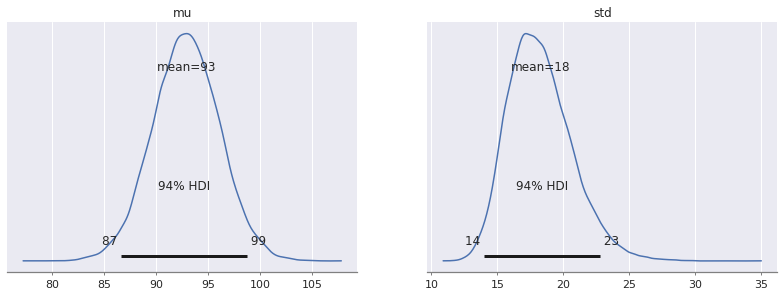

In [12]:
with model_pooled:
    az.plot_posterior(trace_pooled);

In [13]:
#std_pooled_trace = np.array(trace_pooled.posterior["std"]).reshape(-1)
#plt.hist(std_pooled_trace, bins=50);

## Unpooled Bayesian Model

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



* Implement the unpooled model in pymc3

In [14]:
df["machine"] = df["machine"].astype("category")
df["machine_id"] = df["machine"].cat.codes
#df["machine"].cat.categories
#df["machine"].cat.codes
machines = list(df["machine"].cat.categories)
n_machines = len(machines) # number of machines (6)
df.head()

,measurement,machine,quality,machine_id
0,0,M1,83.0,0
1,1,M1,92.0,0
2,2,M1,92.0,0
3,3,M1,46.0,0
4,4,M1,67.0,0


In [15]:
with pm.Model() as model_unpooled:
    group_mu = pm.Normal('group_mu', mu=92.5, sd=100, shape=n_machines)
    group_std = pm.HalfNormal('group_std', sd=100, shape=n_machines)
    y = pm.Normal('y', mu=group_mu[df["machine_id"]], sd=group_std[df["machine_id"]], observed=df["quality"])
    trace_unpooled = pm.sample(10_000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 13 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


In [16]:
with model_unpooled:
    display(az.summary(trace_unpooled))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group_mu[0],76.218,13.875,49.080,102.099,0.108,0.077,19978.0,15259.0,1.0
group_mu[1],105.969,9.351,89.053,123.585,0.081,0.057,20336.0,13783.0,1.0
group_mu[2],87.810,10.166,68.956,106.547,0.105,0.074,15730.0,12704.0,1.0
group_mu[3],111.467,6.038,100.587,122.896,0.052,0.037,20115.0,13020.0,1.0
group_mu[4],90.128,8.233,74.522,104.782,0.073,0.055,18580.0,13995.0,1.0
group_mu[5],85.926,13.960,59.491,112.134,0.123,0.087,17511.0,13148.0,1.0
group_std[0],28.744,15.136,10.511,54.825,0.123,0.087,19772.0,17568.0,1.0
group_std[1],18.134,10.753,6.138,35.592,0.090,0.064,23449.0,15744.0,1.0
group_std[2],19.566,11.634,6.714,38.753,0.110,0.090,20134.0,13622.0,1.0
group_std[3],11.729,7.308,3.953,23.041,0.067,0.047,19092.0,14292.0,1.0


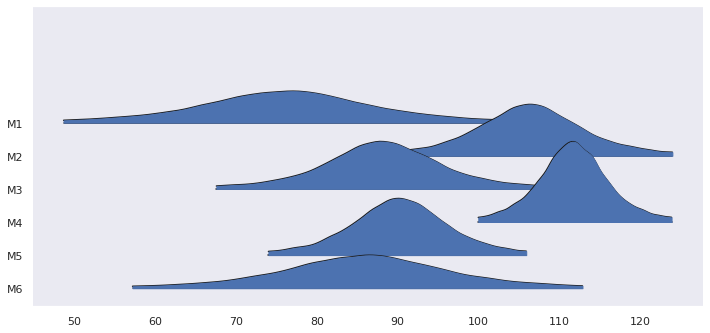

In [17]:
with model_unpooled:
    axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.95, var_names="group_mu", combined=True);
    axes[0].set_yticklabels(machines[::-1])

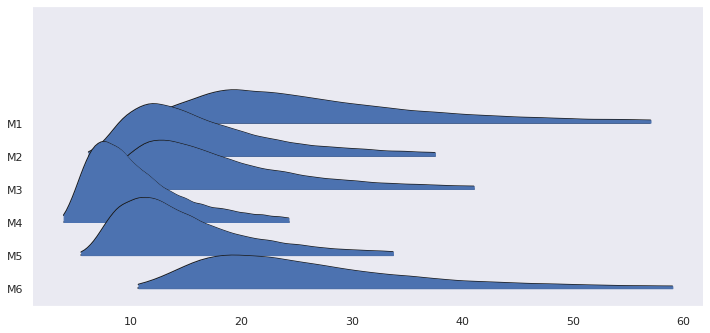

In [18]:
with model_unpooled:
    axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.95, var_names="group_std", combined=True);
    axes[0].set_yticklabels(machines[::-1])

* Compare the sample unpooled standard deviation with the bayesian estimate. What do you observe?

We already computed the sample standard deviations before:

In [19]:
df.groupby("machine")[["quality"]].agg(["mean", "std"])

quality           
           mean        std
machine                   
M1         76.0  19.634154
M2        106.2  11.819475
M3         87.8  12.794530
M4        111.6   7.569676
M5         90.0  10.770330
M6         86.0  19.222383

The posterior means of the bayesian estimates are:

In [20]:
with model_unpooled:
    display(az.summary(trace_unpooled, var_names=["group_std"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group_std[0],28.744,15.136,10.511,54.825,0.123,0.087,19772.0,17568.0,1.0
group_std[1],18.134,10.753,6.138,35.592,0.090,0.064,23449.0,15744.0,1.0
group_std[2],19.566,11.634,6.714,38.753,0.110,0.090,20134.0,13622.0,1.0
group_std[3],11.729,7.308,3.953,23.041,0.067,0.047,19092.0,14292.0,1.0
group_std[4],16.333,9.586,5.888,32.211,0.085,0.063,18984.0,15775.0,1.0
group_std[5],28.457,15.520,10.193,55.822,0.132,0.093,19954.0,16818.0,1.0


In [21]:
#plt.hist(trace_separate["group_std"][:, 5], bins=50);
#trace_std = np.array(trace_separate.posterior["group_std"]).reshape(-1, machines)
#px.histogram(trace_std[:, 0])#, bins=50);

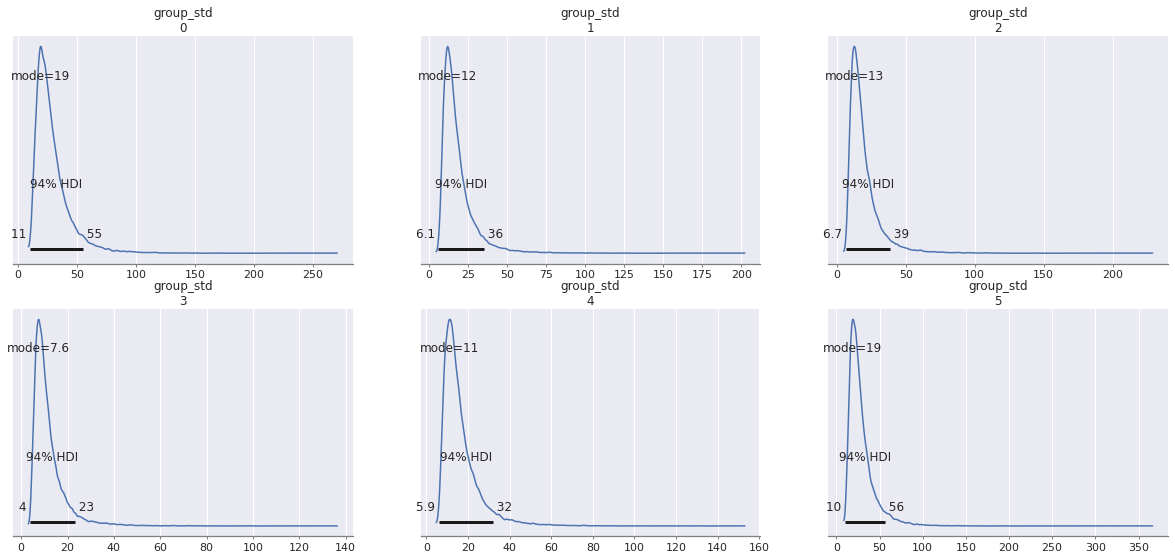

In [22]:
# az.plot_posterior(trace_separate["group_std"][:, 0], point_estimate='mode')
with model_unpooled:
    az.plot_posterior(trace_unpooled, var_names=["group_std"], point_estimate='mode'); # the posterior mean is 29, the mode is 19!

The sample std is rather different from the posterior std mean. The sample std is actually much similar to the posterior mode (as expected from theory)! The posterior std distributions are heaviy right-skewed!

## Hierarchical model, common std

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



* Implement the hierarchical model with common std in pymc3

In [23]:
with pm.Model() as model_hierarchical:
    
    # hyper_priors
    hyper_mu_mu = pm.Normal('hyper_mu_mu', mu=92, sd=100)
    hyper_mu_std = pm.HalfNormal('hyper_mu_std', sd=100)

    # priors    
    group_mu = pm.Normal('group_mu', mu=hyper_mu_mu, sd=hyper_mu_std, shape=n_machines)
    std = pm.HalfNormal('std', sd=100)
    y = pm.Normal('y', mu=group_mu[df["machine_id"]], sd=std, observed=df["quality"])
    trace_hierarchical = pm.sample(10_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, group_mu, hyper_mu_std, hyper_mu_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 15 seconds.
There were 320 divergences after tuning. Increase `target_accept` or reparameterize.
There were 186 divergences after tuning. Increase `target_accept` or reparameterize.
There were 213 divergences after tuning. Increase `target_accept` or reparameterize.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [24]:
az.summary(trace_hierarchical)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hyper_mu_mu,92.915,7.731,79.071,108.164,0.050,0.035,26786.0,22145.0,1.0
group_mu[0],80.010,6.834,66.729,92.524,0.073,0.054,9115.0,3082.0,1.0
group_mu[1],103.066,6.586,90.991,115.743,0.055,0.039,14183.0,9103.0,1.0
group_mu[2],89.012,6.171,76.980,100.194,0.039,0.027,25149.0,23843.0,1.0
group_mu[3],107.177,6.983,94.233,120.642,0.073,0.052,9423.0,6351.0,1.0
group_mu[4],90.691,6.204,79.153,102.603,0.036,0.025,29747.0,23485.0,1.0
group_mu[5],87.646,6.250,75.946,99.580,0.042,0.030,22115.0,19964.0,1.0
hyper_mu_std,15.805,8.999,2.978,31.133,0.096,0.068,4155.0,1700.0,1.0
std,15.268,2.398,11.272,20.006,0.022,0.016,13117.0,8730.0,1.0


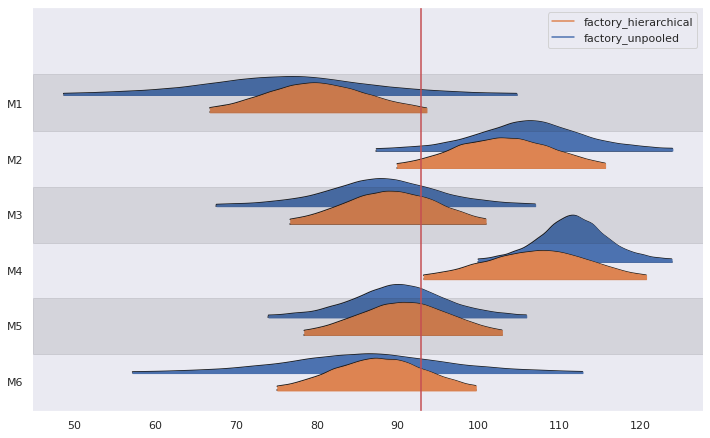

In [25]:
axes = az.plot_forest([trace_unpooled, trace_hierarchical], 
                      model_names=['factory_unpooled', 'factory_hierarchical'], combined=True, kind='ridgeplot', var_names='group_mu', hdi_prob=0.95);

grand_mean = df["quality"].mean()
axes[0].axvline(x=grand_mean, color="r", label="grand_mean");
axes[0].set_yticklabels(machines[::-1]);

In the hierarchical model, the machine means are pushed towards the grand mean

## Model selection 

In [26]:
#with factory_pooled, factory_separate, factory_hierarchical:
comp_df = az.compare({"model_pooled": trace_pooled,
                      "model_unpooled": trace_unpooled,
                      "model_hierarchical": trace_hierarchical},
                     ic="waic", method="BB-pseudo-BMA")
comp_df

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_hierarchical,0,-126.619263,5.420524,0.000000,0.835853,4.335455,0.000000,True,log
model_unpooled,1,-130.259926,8.168072,3.640663,0.108757,2.684545,2.410986,True,log
model_pooled,2,-130.825718,1.993993,4.206454,0.055390,3.939981,2.105500,True,log


In [27]:
comp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_hierarchical,0,-126.619263,5.420524,0.000000,0.835853,4.335455,0.000000,True,log
model_unpooled,1,-130.259926,8.168072,3.640663,0.108757,2.684545,2.410986,True,log
model_pooled,2,-130.825718,1.993993,4.206454,0.055390,3.939981,2.105500,True,log


<AxesSubplot:xlabel='Log'>

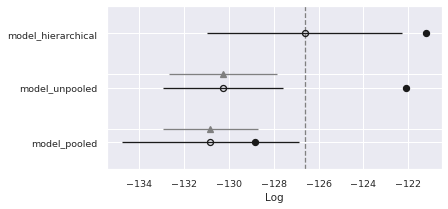

In [28]:
az.plot_compare(comp_df)

## Manual WAIC computations

Let us compare the arviz computation of WAIC with a manual implementation:

In [29]:
with model_hierarchical:
    display(az.waic(trace_hierarchical))

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 40000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -126.62     3.99
p_waic        5.42        -

There has been a warning during the calculation. Please check the results.

In [30]:
log_lik = np.array(trace_hierarchical.log_likelihood.y) # chains, iters, obs
log_lik = log_lik.reshape((-1, log_lik.shape[-1])) # mc samples, obs
S, ny = log_lik.shape

In [31]:
p_waic = np.var(log_lik, axis=0) # correct
p_waic = np.sum(p_waic)
p_waic

5.420523852545883

In [32]:
lppd = scipy.special.logsumexp(log_lik, axis=0) - np.log(S) # sum is equivalent to logsumexp in log domain...
lppd = np.sum(lppd)
lppd

-121.1987393251702

In [33]:
-2*(lppd - p_waic)

253.23852635543216

In [34]:
lppd - p_waic

-126.61926317771608

## With predictive distribution

TODO

In [35]:
with pm.Model() as model_pooled_with_pred:
    mu = pm.Normal('mu', mu=92.5, sd=10)
    std = pm.HalfNormal('std', sd=15)
    y = pm.Normal('y', mu=mu, sd=std, observed=df["quality"])
    
    # Prediction
    y_pred = pm.Normal('y_pred', mu=mu, sd=std)
    trace_pooled_with_pred = pm.sample(10_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_pred, std, mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.


In [36]:
#trace_pooled_with_pred.posterior.y_pred

In [37]:
with pm.Model() as model_hierarchical_with_pred:
    
    # hyper_priors
    hyper_mu_mu = pm.Normal('hyper_mu_mu', mu=92, sd=100)
    hyper_mu_std = pm.HalfNormal('hyper_mu_std', sd=100)

    # priors    
    group_mu = pm.Normal('group_mu', mu=hyper_mu_mu, sd=hyper_mu_std, shape=n_machines)
    std = pm.HalfNormal('std', sd=100)
    y = pm.Normal('y', mu=group_mu[df["machine_id"]], sd=std, observed=df["quality"])
    
    
    pred_mu = pm.Normal('pred_mu', mu=hyper_mu_mu, sd=hyper_mu_std)
    pred_y = pm.Normal('pred_y', mu=pred_mu, sd=std)
    
    
    trace_hierarchical_with_pred = pm.sample(10_000, return_inferencedata=True)
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pred_y, pred_mu, std, group_mu, hyper_mu_std, hyper_mu_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
There were 188 divergences after tuning. Increase `target_accept` or reparameterize.
There were 320 divergences after tuning. Increase `target_accept` or reparameterize.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
There were 211 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [38]:
with pm.Model() as model_hierarchical_with_pred:
    
    # hyper_priors
    hyper_mu_mu = pm.Normal('hyper_mu_mu', mu=92, sd=100)
    hyper_mu_std = pm.HalfNormal('hyper_mu_std', sd=100)

    # priors    
    group_mu = pm.Normal('group_mu', mu=hyper_mu_mu, sd=hyper_mu_std, shape=n_machines)
    std = pm.HalfNormal('std', sd=100)
    y = pm.Normal('y', mu=group_mu[df["machine_id"]], sd=std, observed=df["quality"])
    
    
    pred_mu = pm.Normal('pred_mu', mu=hyper_mu_mu, sd=hyper_mu_std)
    pred_y = pm.Normal('pred_y', mu=pred_mu, sd=std)
    
    
    trace_hierarchical_with_pred = pm.sample(10_000, return_inferencedata=True)
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pred_y, pred_mu, std, group_mu, hyper_mu_std, hyper_mu_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
There were 235 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 564 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7162971316044312, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
